In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
#annots = loadmat('C:\\Users\\llinc\\GitHub\\retina_personal\\0406\\merge\\merge_0224_HMM_RL_G2.5_5min_Q100_6.5mW.mat')
%matplotlib inline

In [2]:
# exp_folder = 'D:\\Leo\\0503'
exp_folder = 'C:\\Users\\llinc\\GitHub\\retina_personal\\0503'
exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2020\\0503'
G = 4.5
annots = loadmat(exp_folder+'\\merge\\'+'merge_0224_OUsmooth_RL_G'+str(G)+'_5min_Q100_6.5mW_1Hz_re.mat')

In [3]:
channelnumber = 12
#os.chdir('C:\\Users\\llinc\\OneDrive\\桌面\\新增資料夾')

In [4]:
from PIfunc import PIfunc
from EqualState import EqualState
def STA(r, x, v, dt, window):
    negshift=round(window[0]/dt) # second
    posshift=round(window[1]/dt) # second
    xSTS = np.zeros(posshift-negshift)
    vSTS = np.zeros(posshift-negshift)
    for i in np.arange(-negshift, len(r)-posshift):
        xSTS = xSTS + x[i+negshift:i+posshift]*r[i]
        vSTS = vSTS + v[i+negshift:i+posshift]*r[i]
    xSTA = xSTS/sum(r[-negshift:len(r)-posshift])
    vSTA = vSTS/sum(r[-negshift:len(r)-posshift])
    time = np.arange(negshift*dt, posshift*dt, dt)
    return time, xSTA, vSTA

(150, 160)

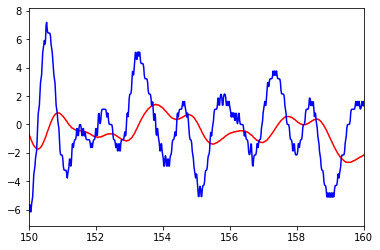

In [5]:
x = np.squeeze(annots['bin_pos'])
x = x.astype(float)
# x = np.random.randn(len(x))
x = (x-np.mean(x))/np.std(x)
dt = 1./60
T=np.squeeze(annots['diode_BT'])
v = ndimage.gaussian_filter1d(x, sigma=1, order=1, mode='wrap') / dt
#v = np.diff(x)/dt
x=x[1:-1]
v=v[1:-1] #cut ends.  V(n) = X(n) -X(n-1)
T=T[1:-1]
#plt.plot(T,L[1:-1], 'm-')
plt.plot(T,x, 'r-')
plt.plot(T,v, 'b-')
plt.xlim(150,160)

In [6]:
x_cor = np.correlate(x, x, "same")
x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
Taxis = np.flip(T[:len(x_cor)]-dt/2)
t_cor = np.interp(0.5*max(x_cor),  x_cor, Taxis)
t_cor

0.7267072741670553

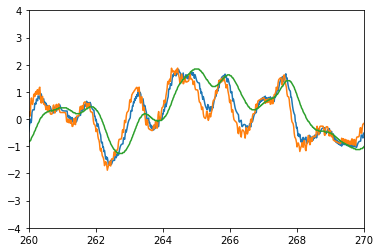

In [7]:
##response
# Model one: simple estimation
deltaT = 0.7
r1 = x+v*deltaT

# Model Two: negative group delay
#following paremeters match x+v*0.5s
alpha = 60.
beta =  2
K = 30.
g = 30.
#following paremeters match x+v*2s
# alpha = 19.9
# beta =  0.62
# K = 10
# g = 30
# alpha = 20.
# beta =  0.3
# K = 20.
# g = 30.
y=np.zeros(len(T))
z=np.zeros(len(T))
for j in range(len(T)-1):
    dy=dt*(-alpha*y[j]+K*(x[j]-z[j]))
    dz=dt*(-beta*z[j]+g*y[j])
    y[j+1]=y[j]+dy
    z[j+1]=z[j]+dz

y= (y-np.mean(y))/np.std(y)
r1= (r1-np.mean(r1))/np.std(r1)
plt.plot(T,y)
plt.plot(T,r1)
plt.plot(T,x)
plt.xlim(260,270)
plt.ylim(-4,4)
    
#Chose which one to be response
r = r1

In [8]:
#assign states
edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
rstate=np.zeros(len(r))
for i in range(4):
    rstate[r>=edges[i]] = i
#rstate = np.random.poisson(rstate)
rstate = rstate.astype(int)
xstate, edges = EqualState(x, 6)
vstate, edges = EqualState(v, 6)
ystate, edges = EqualState(y, 6)

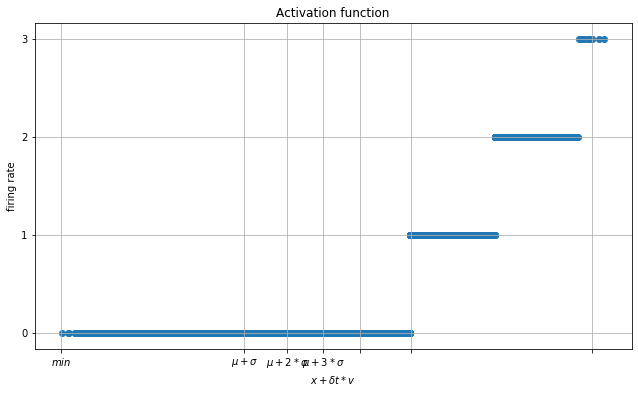

In [9]:
plt.scatter(r, rstate)
plt.title('Activation function')
plt.gcf().set_size_inches(10.7, 6)
plt.xticks(edges, [r'$min$', r'$\mu+\sigma$',r'$\mu+2*\sigma$',r'$\mu+3*\sigma$'])
plt.yticks(np.unique(rstate))
plt.ylabel('firing rate')
plt.xlabel(r'$x+\delta t*v$')
plt.grid(True)
plt.savefig('Active function')

In [10]:
#calculate information
window = [-1,1] # second
timeshift, Information = PIfunc(rstate, xstate, vstate, dt, window)
time, xSTA, vSTA = STA(rstate, x, v, dt, window)
MIx = Information[('Beer','UIx')]+Information[('Beer','Red')]
MIv = Information[('Beer','UIv')]+Information[('Beer','Red')]
MIjoint = Information[('Beer','UIx')]+Information[('Beer','Syn')]+Information[('Beer','UIv')]+Information[('Beer','Red')]

# FUx_peaktime= timeshift[int(np.mean(np.where(Ux == max(Ux))))]
# FUv_peaktime=timeshift[int(np.mean(np.where(Uv == max(Uv))))]
# FSyn_peaktime= timeshift[int(np.mean(np.where(Syner == max(Syner))))]
# FRdn_peaktime= timeshift[int(np.mean(np.where(Redun == max(Redun))))]
# FUx_peakH= max(Ux)
# FUv_peakH= max(Uv)
# FSyn_peakH= max(Syner)
# FRdn_peakH= max(Redun)

C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:80: RuntimeWarning: invalid value encountered in true_divide
  Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:80: RuntimeWarning: divide by zero encountered in log2
  Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:80: RuntimeWarning: invalid value encountered in multiply
  Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:81: RuntimeWarning: divide by zero encountered in log2
  Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt
C:\Users\hydro_leo\Docume

In [11]:
xr_cor = np.correlate(x, rstate, "same")
vr_cor = np.correlate(v, rstate, "same")
(np.squeeze(np.where(xr_cor == max(xr_cor)))-len(T)/2)*dt, (np.squeeze(np.where(vr_cor == max(vr_cor)))-len(T)/2)*dt, (np.squeeze(np.where(vr_cor == min(vr_cor)))-len(T)/2)*dt

(0.3, -0.08333333333333333, 0.6)

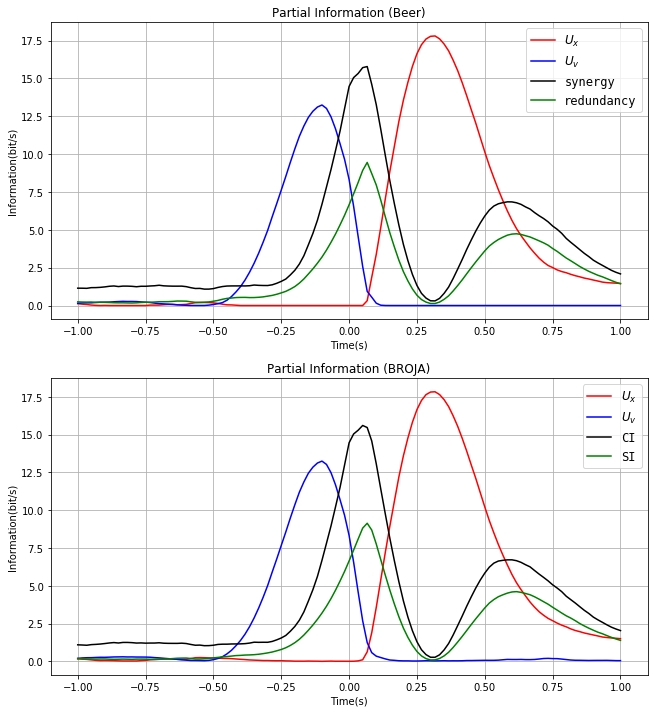

In [12]:
#plot PIs (r,x,v)
fig2, (ax2, ax3) = plt.subplots(nrows=2, ncols=1) 
ax2.plot(timeshift,Information[('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information[('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information[('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information[('Beer','Red')], 'g-')
ax2.set_title('Partial Information (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()

ax3.plot(timeshift,Information[('BROJA_2PID','UIx')], 'r-')
ax3.plot(timeshift,Information[('BROJA_2PID','UIv')], 'b-')
ax3.plot(timeshift,Information[('BROJA_2PID','CI')], 'k-')
ax3.plot(timeshift,Information[('BROJA_2PID','SI')], 'g-')
ax3.set_title('Partial Information (BROJA)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax3.legend( (r'$U_x$', r'$U_v$', 'CI', 'SI'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()

# ax4.plot(timeshift,Information[('test','UIx')], 'r-')
# ax4.plot(timeshift,Information[('test','UIv')], 'b-')
# ax4.set_title('Partial Information (test)')
# ax4.set_xlabel('Time(s)')
# ax4.set_ylabel('Information(bit/s)')
# ax4.legend( (r'$U_x$', r'$U_v$', 'CI', 'SI'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# ax4.grid()

plt.gcf().set_size_inches(10.7, 12)
# plt.savefig(str(deltaT)+'_fake_spike_PI.tiff')

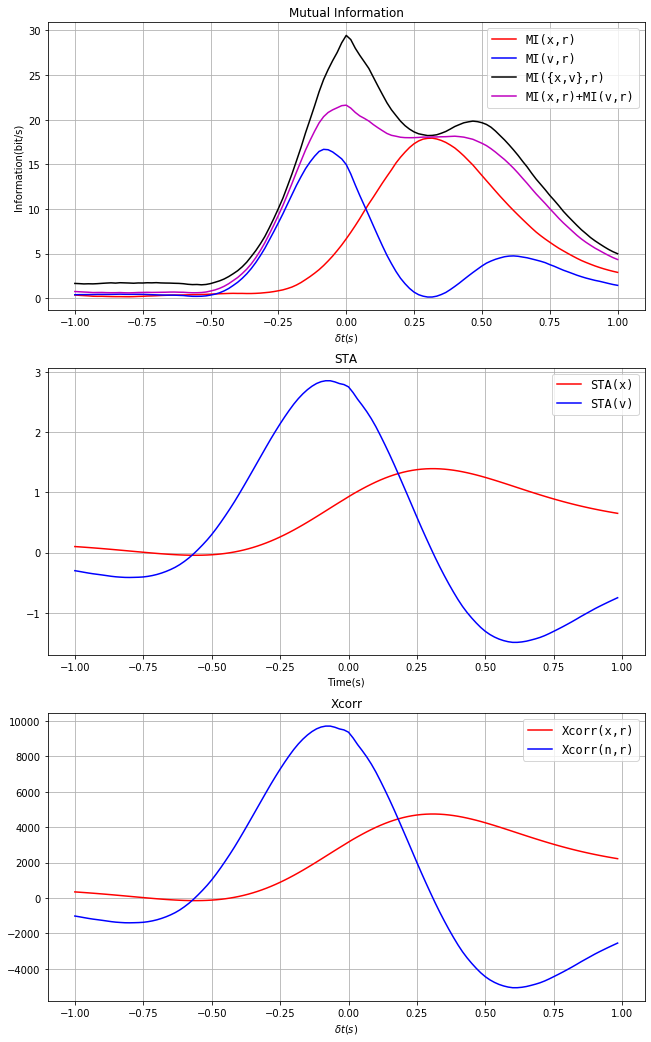

In [13]:
#plot MIs
fig2, (ax2, ax3, ax4) = plt.subplots(nrows=3, ncols=1) 
ax2.plot(timeshift,MIx, 'r-')
ax2.plot(timeshift,MIv, 'b-')
ax2.plot(timeshift,MIjoint, 'k-')
ax2.plot(timeshift,MIx+MIv, 'm-')
ax2.set_title('Mutual Information')
ax2.set_xlabel(r'$\delta t(s)$')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})

ax3.plot(time,xSTA,'r-')
ax3.plot(time,vSTA, 'b-')
ax3.set_title('STA')
ax3.set_xlabel('Time(s)')
ax3.legend( ('STA(x)', 'STA(v)'), loc='best', prop={'size': 'large', 'family': 'monospace'})

ax4.plot(time,xr_cor[int(len(T)/2-len(time)/2):int(len(T)/2+len(time)/2)], 'r-')
ax4.plot(time,vr_cor[int(len(T)/2-len(time)/2):int(len(T)/2+len(time)/2)], 'b-')
ax4.set_title('Xcorr')
ax4.set_xlabel(r'$\delta t(s)$')
ax4.legend( ('Xcorr(x,r)', 'Xcorr(n,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})

ax4.grid()
ax3.grid()
ax2.grid()
plt.gcf().set_size_inches(10.7, 18)
plt.savefig(str(deltaT)+'_fake_spike_MI.tiff')

In [14]:
# for i in range(np.size(annots['reconstruct_spikes'])):
#     print( i, np.size(annots['reconstruct_spikes'][0][i]))

In [15]:
N, edges = np.histogram(annots['reconstruct_spikes'][0][channelnumber-1], np.append(0,T))
np.unique(N)

array([0, 1, 2, 3, 4], dtype=int64)

In [16]:
#calculate information
window = [-1,1] # second
timeshift, Information = PIfunc(rstate, xstate, vstate, dt, window)
time, xSTA, vSTA = STA(N, x, v, dt, window)
MIx = Information[('Beer','UIx')]+Information[('Beer','Red')]
MIv = Information[('Beer','UIv')]+Information[('Beer','Red')]
MIjoint = Information[('Beer','UIx')]+Information[('Beer','Syn')]+Information[('Beer','UIv')]+Information[('Beer','Red')]
# RUx_peaktime= timeshift[int(np.mean(np.where(Ux == max(Ux))))]
# RUv_peaktime=timeshift[int(np.mean(np.where(Uv == max(Uv))))]
# RSyn_peaktime= timeshift[int(np.mean(np.where(Syner == max(Syner))))]
# RRdn_peaktime= timeshift[int(np.mean(np.where(Redun == max(Redun))))]
# RUx_peakH= max(Ux)
# RUv_peakH= max(Uv)
# RSyn_peakH= max(Syner)
# RRdn_peakH= max(Redun)

C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:80: RuntimeWarning: invalid value encountered in true_divide
  Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:80: RuntimeWarning: divide by zero encountered in log2
  Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:80: RuntimeWarning: invalid value encountered in multiply
  Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:81: RuntimeWarning: divide by zero encountered in log2
  Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt
C:\Users\hydro_leo\Docume

In [17]:
xr_cor = np.correlate(x, N, "same")
vr_cor = np.correlate(v, N, "same")
(np.squeeze(np.where(xr_cor == max(xr_cor)))-len(T)/2)*dt, (np.squeeze(np.where(vr_cor == max(vr_cor)))-len(T)/2)*dt, (np.squeeze(np.where(vr_cor == min(vr_cor)))-len(T)/2)*dt

(0.23333333333333334, -0.31666666666666665, 95.41666666666667)

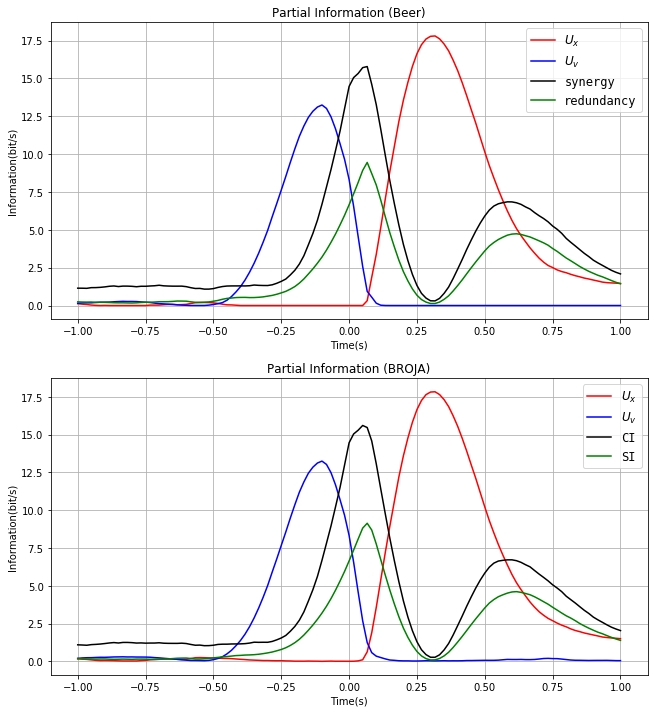

In [18]:
#plot PIs (r,x,v)
fig2, (ax2, ax3) = plt.subplots(nrows=2, ncols=1) 
ax2.plot(timeshift,Information[('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information[('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information[('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information[('Beer','Red')], 'g-')
ax2.set_title('Partial Information (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()

ax3.plot(timeshift,Information[('BROJA_2PID','UIx')], 'r-')
ax3.plot(timeshift,Information[('BROJA_2PID','UIv')], 'b-')
ax3.plot(timeshift,Information[('BROJA_2PID','CI')], 'k-')
ax3.plot(timeshift,Information[('BROJA_2PID','SI')], 'g-')
ax3.set_title('Partial Information (BROJA)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax3.legend( (r'$U_x$', r'$U_v$', 'CI', 'SI'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()

# ax4.plot(timeshift,Information[('test','UIx')], 'r-')
# ax4.plot(timeshift,Information[('test','UIv')], 'b-')
# ax4.set_title('Partial Information (test)')
# ax4.set_xlabel('Time(s)')
# ax4.set_ylabel('Information(bit/s)')
# ax4.legend( (r'$U_x$', r'$U_v$', 'CI', 'SI'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# ax4.grid()

plt.gcf().set_size_inches(10.7, 12)
# plt.savefig(str(deltaT)+'_fake_spike_PI.tiff')

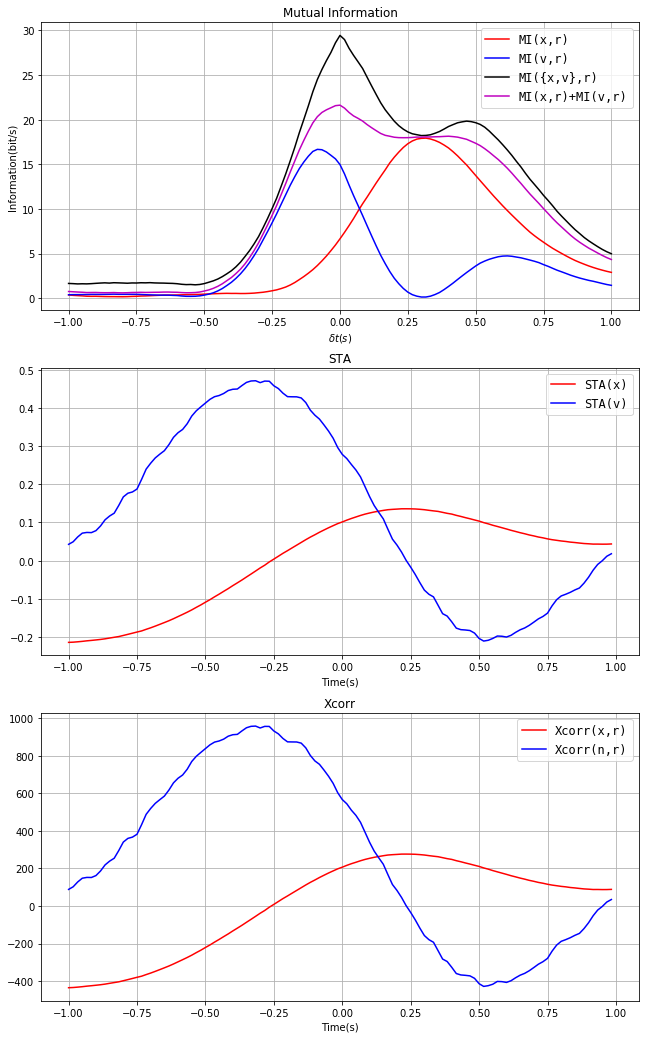

In [19]:
#plot MIs
fig2, (ax2, ax3, ax4) = plt.subplots(nrows=3, ncols=1) 
ax2.plot(timeshift,MIx, 'r-')
ax2.plot(timeshift,MIv, 'b-')
ax2.plot(timeshift,MIjoint, 'k-')
ax2.plot(timeshift,MIx+MIv, 'm-')
ax2.set_title('Mutual Information')
ax2.set_xlabel(r'$\delta t(s)$')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})

ax3.plot(time,xSTA,'r-')
ax3.plot(time,vSTA, 'b-')
ax3.set_title('STA')
ax3.set_xlabel('Time(s)')
ax3.legend( ('STA(x)', 'STA(v)'), loc='best', prop={'size': 'large', 'family': 'monospace'})

ax4.plot(time,xr_cor[int(len(T)/2-len(time)/2):int(len(T)/2+len(time)/2)], 'r-')
ax4.plot(time,vr_cor[int(len(T)/2-len(time)/2):int(len(T)/2+len(time)/2)], 'b-')
ax4.set_title('Xcorr')
ax4.set_xlabel('Time(s)')
ax4.legend( ('Xcorr(x,r)', 'Xcorr(n,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})

ax4.grid()
ax3.grid()
ax2.grid()
plt.gcf().set_size_inches(10.7, 18)
plt.savefig('ch.'+str(channelnumber)+'_MI.tiff')
# plt.ylabel('Information(bit/s)')
# plt.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})

In [20]:
len(T)/2-len(time)/2

8942.0

In [21]:
#plz ignore following

In [22]:
max(Uv)/max(Ux)

NameError: name 'Uv' is not defined

In [ ]:
print(RUv_peaktime, FUv_peaktime)
print(RSyn_peaktime-RUv_peaktime, FSyn_peaktime-FUv_peaktime)
print(RRdn_peaktime-RUv_peaktime, FRdn_peaktime-FUv_peaktime)
print(RUx_peaktime-RUv_peaktime, FUx_peaktime-FUv_peaktime)
print('if matched, the progressing time = '+str(round(FUv_peaktime-RUv_peaktime, 3))+'(s)')

In [ ]:
print(RUv_peakH, FUv_peakH)
print(RSyn_peakH/RUv_peakH, FSyn_peakH/FUv_peakH)
print(RRdn_peakH/RUv_peakH, FRdn_peakH/FUv_peakH)
print(RUx_peakH/RUv_peakH, FUx_peakH/FUv_peakH)

In [ ]:
plt.scatter(rstate, N)
plt.grid(True)

In [ ]:
hst = plt.hist2d(r, N)

In [ ]:
Nn = N[np.where(N != 0)]
Rr = r[np.where(N != 0)]
hst = plt.hist2d(Rr, Nn)

In [ ]:
Rr = Rr[np.where(Nn != 1)]
Nn = Nn[np.where(Nn != 1)]
hst = plt.hist2d(Rr, Nn)